In [1]:
import numpy as np
import pylab as pl
import matplotlib.gridspec as gridspec
from glob import glob
import tensorflow as tf
import numpy.ma as ma
import sys,os
from datetime import datetime, timedelta
import myfunc.util as util
from collections import deque
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
def mk_daylist(days=None, rat_train=1.0):
    nall   = days
    ntrain = int(nall*rat_train)
    np.random.seed(0)

    a1idx = range(nall)
    a1idx = np.random.choice(a1idx, len(a1idx), replace=False)
    a1idx_train = a1idx[:ntrain]
    a1idx_valid = a1idx[ntrain:]

    return a1idx_train,a1idx_valid


def read_Tc(lDTime=None, ldydx=None, isurf=None):
    a2tc = deque([])
    for DTime in lDTime:
        Year,Mon,Day = DTime.timetuple()[:3]
        a2tcTmp = None
        for idydx,(dy,dx) in enumerate(ldydx):
            #srcDir = '/work/hk01/utsumi/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcDir = '/mnt/j/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcPath1=srcDir + '/Tc1.%ddy.%ddx.%02dsurf.npy'%(dy,dx,isurf)
            srcPath2=srcDir + '/Tc2.%ddy.%ddx.%02dsurf.npy'%(dy,dx,isurf)
            if not os.path.exists(srcPath1): continue
            atc1 = np.load(srcPath1)
            atc2 = np.load(srcPath2)
            atc  = np.c_[atc1, atc2]

            try:
                a2tcTmp = np.c_[a2tcTmp, atc]
            except ValueError:
                a2tcTmp = atc

        if a2tcTmp is None:
            continue
        else:
            a2tcTmp = np.array(a2tcTmp)
        #**********************
        a2tc.extend(a2tcTmp)

    return np.array(a2tc)

def read_var_collect(varName=None, lDTime=None, ldydx=None, isurf=None):
    a2var = deque([])
    for DTime in lDTime:
        Year,Mon,Day = DTime.timetuple()[:3]
        a2varTmp = None
        for idydx,(dy,dx) in enumerate(ldydx):
            #srcDir = '/work/hk01/utsumi/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcDir = '/mnt/j/PMM/stop/data/%s/%04d/%02d/%02d'%(varName,Year,Mon,Day)
            srcPath=srcDir + '/%s.%ddy.%ddx.%02dsurf.npy'%(varName,dy,dx,isurf)
            if not os.path.exists(srcPath): continue
            avar = np.load(srcPath)

            try:
                a2varTmp = np.c_[a2varTmp, avar]
            except ValueError:
                a2varTmp = avar

        if a2varTmp is None:
            continue
        else:
            a2varTmp = np.array(a2varTmp)
        #**********************
        a2var.extend(a2varTmp)
    return np.array(a2var)

def read_pc_coef(isurf):
    #*********************************
    # Read PC coefficient
    #*********************************
    #coefDir = '/work/hk01/utsumi/PMM/stop/data/coef'
    coefDir = '/mnt/j/PMM/stop/data/coef'
    egvecPath = coefDir + '/egvec.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    egvalPath = coefDir + '/egval.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    varratioPath = coefDir + '/varratio.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    
    a2egvec = np.load(egvecPath)  # (n-th, ncomb)
    a1varratio = np.load(varratioPath)
    a1cumvarratio= np.cumsum(a1varratio)
    return a2egvec, a1varratio, a1cumvarratio

def my_unit(x,Min,Max):
    return (x-Min)/(Max-Min)


print 'Define functions'

ldy   = [-1,0,1]
ldx   = [-3,-2,-1,0,1,2,3]
#ldx   = [-2,-1,0,1,2]
imid  = int((len(ldy)*len(ldx)-1)/2)
ldydx = [[dy,dx] for dy in ldy for dx in ldx]
isurf = 1
ldays_train,ldays_valid = mk_daylist(days=31, rat_train=0.2)
lDTime_train = [datetime(2017,1,1)+timedelta(days=i) for i in ldays_train]
lDTime_valid = [datetime(2017,1,1)+timedelta(days=i) for i in ldays_valid]


trainTc   = read_Tc(lDTime_train, ldydx, isurf)
trainStop = read_var_collect('stop', lDTime_train, ldydx, isurf)
trainLat  = read_var_collect('Latitude', lDTime_train, [[0,0]], isurf)

print trainTc.shape, trainStop.shape, trainLat.shape

Define functions
(179239, 273) (179239, 21) (179239,)


In [3]:
#latmin = -30
#latmax = 30
latmin=-90
latmax=-20

index_keep = []
for i in range(trainTc.shape[0]):
    lat = trainLat[i]
    if (latmin<=lat)and(lat<=latmax):
        index_keep.append(i)
print len(index_keep)
trainTc   = trainTc[index_keep]
trainStop = trainStop[index_keep]
trainLat  = trainLat[index_keep]
print trainTc.shape, trainStop.shape, trainLat.shape

75874
(75874, 273) (75874, 21) (75874,)


In [4]:
nstorm = 1
#nstorm = 21
nostorm = len(ldy)*len(ldx)-nstorm
if nstorm >1:
    a1flagstop = ((trainStop>=0).sum(axis=1) >=nstorm)
    trainTc   = trainTc[a1flagstop]
    trainStop = trainStop[a1flagstop]
trainTc.shape, trainStop.shape
trainStop = trainStop[:,imid].reshape(-1,1)
print trainTc.shape, trainStop

(75874, 273) [[1506.4084]
 [1671.7852]
 [2204.2183]
 ...
 [2432.14  ]
 [1643.8267]
 [1565.1613]]


In [5]:
# PC parameters
restriction = 10
#restriction = 20
amean = trainTc.mean(axis=0)
astd  = trainTc.std(axis=0)
pca = PCA(n_components=restriction)
pca.fit((trainTc-amean)/astd)
a2egvec=pca.components_
#a1egval=pca.explained_variance
a1varratio=pca.explained_variance_ratio_
print 'amean',amean
print 'astd',astd

amean [168.67473  100.1354   197.53105  142.69406  223.58284  227.11801
 186.86955  255.51662  239.57068  256.48926  251.74808  249.20486
 254.76103  168.80101  100.357895 197.80608  143.19298  223.78047
 227.4591   187.57716  255.37082  239.61072  256.0502   251.23547
 249.11429  254.51726  168.89548  100.51855  198.03615  143.60532
 223.94286  227.73792  188.17006  255.22519  239.59451  255.65324
 250.75636  249.04677  254.30371  168.91492  100.55033  198.06458
 143.65985  223.95013  227.74615  188.2018   255.10976  239.4248
 255.4906   250.53671  249.02486  254.22903  168.84616  100.4294
 197.83327  143.23863  223.73535  227.42476  187.52782  255.09595
 239.15033  255.72368  250.77148  249.07968  254.37816  168.71759
 100.201    197.48776  142.59831  223.40678  226.98369  186.59679
 255.14609  238.87177  256.14206  251.23877  249.1728   254.62996
 168.5688    99.933266 197.15141  141.97833  223.08614  226.5698
 185.72148  255.18892  238.61803  256.53033  251.66734  249.25587
 254.85

In [6]:
# resample
resample_rate = 1.0
N = int(trainTc.shape[0]*resample_rate)
aidx = np.random.choice(np.arange(trainTc.shape[0]), N).astype('int32')
trainTc  = trainTc[aidx,:]
trainStop= trainStop[aidx,:]
print trainTc.shape, trainStop.shape

(75874, 273) (75874, 1)


In [7]:
trainTc = (trainTc-amean)/astd
#reduction = np.dot(trainTc, a2egvec[:restriction,:].T)
reduction = np.dot(trainTc, a2egvec[:restriction,:].T)

In [10]:
#*** Save preprocess parameters *******
Mon=1
preptype = 'nynx.%dx%d.isurf.%d.Mon.%d.Lat.%d.%d'%(len(ldy),len(ldx),isurf,Mon,latmin,latmax)
paramDir = '/mnt/j/PMM/stop/prep-param/%s'%(preptype)
util.mk_dir(paramDir)

#*** Save Tc mean, std *******
meanPath = paramDir + '/mean.Tc.npy'
stdPath  = paramDir + '/std.Tc.npy'
np.save(meanPath, amean)
np.save(stdPath,  astd)

#*** PC coefficient (eigen vector)
egvecPath = paramDir + '/egvec.npy'
#egvalPath = paramDir + '/egval.npy'
varratioPath = paramDir + '/varratio.npy'
np.save(egvecPath, a2egvec.astype('float32'))
np.save(varratioPath, a1varratio.astype('float32'))

#*** PC min, max ***************
minPath = paramDir + '/pc.min.npy'
maxPath = paramDir + '/pc.max.npy'
np.save(minPath, reduction.min(axis=0))
np.save(maxPath, reduction.max(axis=0))
print minPath

/mnt/j/PMM/stop/prep-param/nynx.3x7.isurf.1.Mon.1.Lat.-90.-20/pc.min.npy


In [11]:
#Max = [ np.max(Glabel[i]) for i in range(14) ]
#Min = [ np.min(Glabel[i]) for i in range(14) ]
#Max =  np.max(trainStop)
#Min =  np.min(trainStop)
MinStop = 0
MaxStop = 32000
#MinRed, MaxRed = -590, 1929

print reduction.min(),reduction.max()

def unit(x):
    return ( x - np.min(x,0) )/( np.max(x,0) - np.min(x,0) )

-590.8039 1928.887


In [12]:
aidx = np.random.choice(np.arange(len(trainStop)), len(trainStop))
nTrain = int(len(aidx)*0.9)
aidxTrain = aidx[:nTrain]
aidxTest  = aidx[nTrain:]

print trainStop.shape
print nTrain
print reduction.shape
trainX = unit(reduction)
#trainY = unit(trainStop)
#trainX = my_unit(reduction,MinRed,MaxRed)
trainY = my_unit(trainStop,MinStop,MaxStop)

testX = trainX[aidxTest]
testY = trainY[aidxTest]
trainX= trainX[aidxTrain]
trainY= trainY[aidxTrain]

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

print 'reduction=',reduction
print 'reduction.min, max',reduction.min(), reduction.max()
print 'trainX.min, max', trainX.min(), trainX.max()

(75874, 1)
68286
(75874, 10)
((68286, 10), (68286, 1), (7588, 10), (7588, 1))
reduction= [[ 1.1410028   0.45172924 -0.41789272 ...  0.60363996 -0.00486456
  -0.12276661]
 [-0.42342505  0.17509787 -0.1280708  ...  0.29422832 -0.25222287
   0.10674152]
 [-0.62152684 -0.10087861 -0.4709673  ... -0.10944871 -0.24449506
  -0.82103467]
 ...
 [-3.1644602  -0.2591672   0.8345165  ...  0.76006913  0.18561949
  -0.20415023]
 [ 1.7654954   0.5230044  -0.56741613 ...  0.15257972  0.23407608
  -0.09354596]
 [ 1.6993976   0.4684761  -0.55782473 ...  0.22944903 -0.01163778
  -0.07017997]]
reduction.min, max -590.8039 1928.887
trainX.min, max 0.0 1.0


[0.00000000e+00 1.46445046e-05 2.92890093e-05 ... 9.99970711e-01
 9.99985355e-01 1.00000000e+00]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.46445046e-05 2.14461516e-10 ... 3.09793411e-44
  4.53677105e-49 6.64387647e-54]
 [1.00000000e+00 2.92890093e-05 8.57846066e-10 ... 1.58614226e-41
  4.64565355e-46 1.36066590e-50]
 ...
 [1.00000000e+00 9.99970711e-01 9.99941423e-01 ... 9.99736430e-01
  9.99707149e-01 9.99677868e-01]
 [1.00000000e+00 9.99985355e-01 9.99970711e-01 ... 9.99868207e-01
  9.99853565e-01 9.99838922e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


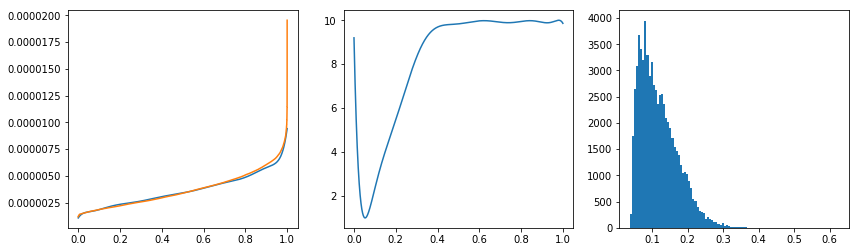

In [13]:
def FFN(TraX, TraY, TesX, TesY, learning_rate, epochs, batch_size, dim, act): 
    fn1 = tf.nn.sigmoid
    fn2 = tf.nn.relu
    def fn3(x):
        return x/(1+np.abs(x))
    ac  = [fn1,fn3,fn1,fn3,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1] # number of entry = len(dim) - 2
    total_batch = int(len(TraX)/batch_size) + 1
    Xdata = [ TraX[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]
    Ydata = [ TraY[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, TraX.shape[1]], 'input')
    Y = tf.placeholder(tf.float32, [None, TraY.shape[1]])
        
    W = [ tf.Variable(tf.random_normal([dim[i], dim[i+1]]), name='w%d'%(i)) for i in range(len(dim) - 1) ]
    b = [ tf.Variable(tf.random_normal([dim[i+1]]), name='b%d'%(i))         for i in range(len(dim) - 1) ]
    A = [ X ]
    for i in range(len(dim) - 2):
        A.append(ac[i](tf.matmul(A[-1], W[i]) + b[i]))
    A.append(tf.matmul(A[-1], W[-1]) + b[-1])  
    if act == 0:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1]) ))) 
    elif act == 1:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*error_function(Y,label,100,12,1,bpara) ))) 
    elif act == 2:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*my_error_func(Y, coef_poly )))) 

    gogo = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    real = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    pred = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    rmse = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(real - pred))))
    prediction=tf.add(tf.matmul(A[-2], W[-1]), b[-1], name='pred')  # for Save
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    #*** Saver ********
    saver = tf.train.Saver(max_to_keep=3)
    #******************

    for epoch in range(epochs):    
        for i in range(total_batch):
            feed1 = {X:Xdata[i], Y:Ydata[i]}
            sess.run(gogo, feed_dict = feed1)
            training_error = sess.run(cost, feed_dict = feed1)
            prediction     = sess.run(A[-1], feed_dict = {X:TesX})
            test_error     = sess.run(rmse, feed_dict = {real:TesY, pred:prediction})
        if epoch % int(epochs/5) == 0:    
            print('Training Error:',training_error,'and','Testing Error:', test_error)

            #**** Save **********************
            #ckptDir = '/work/hk01/utsumi/PMM/stop/ml-param-%d'%(act)
            ckptDir = '/mnt/j/PMM/stop/ml-param/%s'%(expr)
            util.mk_dir(ckptDir)
            ckptPath= ckptDir + '/stop.%02d'%(isurf)
            sv = saver.save(sess, ckptPath)
            #******************************** 
            
    return prediction


#def my_unit(x,Min,Max):
#    return (x-Min)/(Max-Min)

def mk_coef_polyfit(a1obs, degree, coef_b):
    # a1obs must be in range of [0,1]
    nbins = 100
    a1bnd = np.arange(nbins+1).astype('float32')/(nbins)
    frequency,_ = np.histogram(a1obs, bins=a1bnd)
    g = (coef_b - 1)*(-frequency/float(frequency.max()) +1)+1
    x = 0.5*(a1bnd[:-1]+a1bnd[1:])
    coef = np.polyfit(x,g,deg=degree)  # highest degree coef first.
    print 'coef.shape=',coef.shape
    return coef[::-1]

def my_error_func(a1obs, coef):
    degree = len(coef)-1
    for i in range(degree+1):
        if i==0:
            y = coef[i]*(a1obs**i)
        else:
            y = y + coef[i]*(a1obs**i)
    return y


    
def error_function(x, data, bins, degree, Min, Max):
    vec       = ((data - np.min(data,0))/float(np.max(data,0)-np.min(data,0)))
    interval  = [ i/float(bins) for i in range(bins + 1)]
    frequency = np.array([ ((vec<=interval[i+1]).sum() - (vec<interval[i]).sum())/float(len(vec)) for i in range(bins) ])
    xx        = np.arange(bins)/float(bins - 1)
    mat       = np.concatenate([(xx**i).reshape(-1,1) for i in range(degree)], axis=1)
    #print mat
    #print frequency
    coef      = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, frequency))
    poly      = 1 - sum([coef[i]*(x**i) for i in range(degree)])
    values    = 1 - sum([coef[i]*(xx**i) for i in range(degree)])
    M, N      = np.max(values), np.min(values)
    return (Max - Min)/float(M - N)*(poly - N) + Min 
def uniformize(reduction, label):
    mat = np.concatenate([reduction, label], axis=1)
    temporary = []
    for i in range(mat.shape[1]):
        a = np.arange(len(mat)).reshape(-1,1)
        b = np.concatenate([a,mat[:,[i]]], axis=1)
        c = b[b[:,1].argsort()]
        c[:,1] = np.arange(len(mat))/(len(mat)-1)
        d = c[c[:,0].argsort()]
        temporary.append(d[:,1])
    input_data = (np.array(temporary).T)[:, :-1]
    target     = (np.array(temporary).T)[:,[-1]]
    return input_data, target
def rmse(x,y):
    x = x.flatten()
    y = y.flatten()
    return np.sqrt((((x-y))**2).mean())
def Rmse(x,y):
    Min,Max=MinStop,MaxStop
    return np.sqrt( ( ( ((Max-Min)*x+Min).flatten()-((Max-Min)*y+Min).flatten() )**2 ).mean() )
def cc(x,y):
    return np.corrcoef( x.flatten(), y.flatten() )[0,1]
def sort(x):
    return np.sort(x.flatten())
def unit(x):
    return (x-np.min(x,0))/(np.max(x,0)-np.min(x,0))
def f_act(x,label):
    degree = 12
    #y_val = np.sort(unit(label.flatten()))
    y_val = np.sort(my_unit(label.flatten(),MinStop,MaxStop))
    X     = (np.arange(len(y_val))/float(len(y_val)-1) )
    mat   = np.concatenate([(X**i).reshape(-1,1) for i in range(degree)], axis=1)
    print X
    print mat
    coef  = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, y_val))
    poly  = sum([coef[i]*(x**i) for i in range(degree)])
    return poly
x = np.arange(100001)/float(100000)
pl.figure(figsize=(14,4))
pl.subplot(131)
pl.plot(x,f_act(x,trainY))
#pl.plot(np.arange(len(trainY))/float(len(trainY)-1),np.sort(unit(trainY.flatten())))
pl.plot(np.arange(len(trainY))/float(len(trainY)-1),np.sort(my_unit(trainY.flatten(),MinStop,MaxStop)))
pl.subplot(132)
pl.plot(x, error_function(x, trainY, 100, 12, 1, 10))
pl.subplot(133)
_,_,_ = pl.hist(trainY, 100)

In [14]:
def Figure(Label, Prediction, bins):
    Min,Max = MinStop, MaxStop
    recover_testY = (Max-Min)*Label.flatten()      + Min
    recover_pred  = (Max-Min)*Prediction.flatten() + Min

    pl.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])
    
    pl.subplot(gs[0,:])
    pl.plot(recover_testY/1000., c='r', label ='Observation')
    pl.plot(recover_pred /1000., c='b', label ='Prediction')
    pl.ylabel('height(km)')
    pl.ylim([0,18])
    pl.legend()
    pl.title('non-storm<=%d act=%d b=%d lat=[%.1f, %.1f] box=%dx%d'%(nostorm,act, bpara,latmin, latmax, len(ldy),len(ldx)))
    print('RMSE:'     , np.round(rmse(Label, Prediction) , 4))
    print('real RMSE:', np.round(Rmse(Label, Prediction) , 4))
    print('CC:'       , np.round(  cc(Label, Prediction) , 4))
    
    pl.subplot(gs[2]) # values prediction and testY are between -4 and 4
    aa = recover_pred
    bb = recover_testY
    interval           = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    interval1          = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    revised_interval   = interval[:-1]  + (Max - Min)/(2*bins)
    revised_interval1  = interval1[:-1] + (Max - Min)/(2*bins)
    cumulative_number  = []
    cumulative_number1 = []
    for i in range(bins):
        cumulative_number.append(  (aa < interval[i+1] ).sum() - (aa < interval[i] ).sum() )
        cumulative_number1.append( (bb < interval1[i+1]).sum() - (bb < interval1[i]).sum() )
    pl.plot(revised_interval/.1000          , cumulative_number   , color='green', alpha=0.5, label='Prediction')    
    pl.fill_between(revised_interval/.1000  , cumulative_number, 0, color='green', alpha=0.5)
    pl.plot(revised_interval1/.1000         , cumulative_number1  , color='red'  , alpha=0.5 ,label='Observation')    
    pl.fill_between(revised_interval1/.1000 ,cumulative_number1, 0, color='red'  , alpha=0.5)
    pl.ylabel('number of samples')
    pl.xlabel('height(km)')
    pl.legend() 
    pl.title('Distribution')
    pl.legend()

    #*** 2D histogram **********
    H,xbnd,ybnd = np.histogram2d(recover_testY/1000, recover_pred/1000, bins=[np.arange(0,20,0.5), np.arange(0,20,0.5)])
    H = ma.masked_equal(H,0)
    X,Y = np.meshgrid(xbnd,ybnd)
    pl.subplot(gs[3])
    pl.pcolormesh(X,Y,H.T, cmap='jet')
    pl.axis([0,18,0,18])
    pl.xticks([0,5,10,15])
    pl.yticks([0,5,10,15])
    pl.plot([0,35],[0,35],'k')
    pl.xlabel('Observation(km)')
    pl.ylabel('Prediction(km)')
    pl.title('Correlation')
    pl.grid()
    pl.colorbar()
    
    #pl.scatter(recover_testY/1000, recover_pred/1000,s=3)
    #pl.plot(np.arange(18000)/1000,np.arange(18000)/1000,c='black',linestyle = ':')
    #pl.axis([0,18,0,18])
    #pl.xticks([0,5,10,15])
    #pl.yticks([0,5,10,15])
    #pl.xlabel('Observation(km)')
    #pl.ylabel('Prediction(km)')
    #pl.title('Correlation')
    #pl.grid()

In [15]:
bpara  = 5
degree = 12
coef_b = bpara
coef_poly  = mk_coef_polyfit(testY, degree, coef_b)

coef.shape= (13,)


/home/utsumi/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:71: RankWarning: Polyfit may be poorly conditioned


In [16]:
# Apply error function
#Train, Label = unit(reduction), unit(label)
#ntrain       = int(0.7*len(reduction))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
#dim = [trainX.shape[2], 30, 30, 30,10, trainY.shape[1]]
dim = [trainX.shape[1], 30, 30, 30,10, trainY.shape[1]]
act = 2
expr= 'surf%d.b%d.lat.%d.%d'%(isurf,bpara,latmin,latmax)
prediction   = FFN(trainX, trainY, testX, testY, 0.005, 50, 1024*4, dim, act)
#prediction   = FFN(trainX, trainY, testX, testY, 0.005, 150, 1024*4, dim, act)
print 'testX.min, max', testX.min(), testX.max()
print 'testY.min, max', testY.min(), testY.max()
print 'prediction.min, max',prediction.min(),prediction.max()

((68286, 10), (68286, 1), (7588, 10), (7588, 1))
('Training Error:', 0.15041396, 'and', 'Testing Error:', 0.10014132)
('Training Error:', 0.064158574, 'and', 'Testing Error:', 0.037868336)
('Training Error:', 0.059822302, 'and', 'Testing Error:', 0.034246244)
('Training Error:', 0.059024323, 'and', 'Testing Error:', 0.033922322)
('Training Error:', 0.05872242, 'and', 'Testing Error:', 0.033828996)
testX.min, max 0.0 1.0
testY.min, max 0.03722722 0.36570093
prediction.min, max 0.04188454 0.32584488


In [17]:
print prediction.min(),prediction.max()

0.04188454 0.32584488


('RMSE:', 0.0338)
('real RMSE:', 1081.1075)
('CC:', 0.7731)


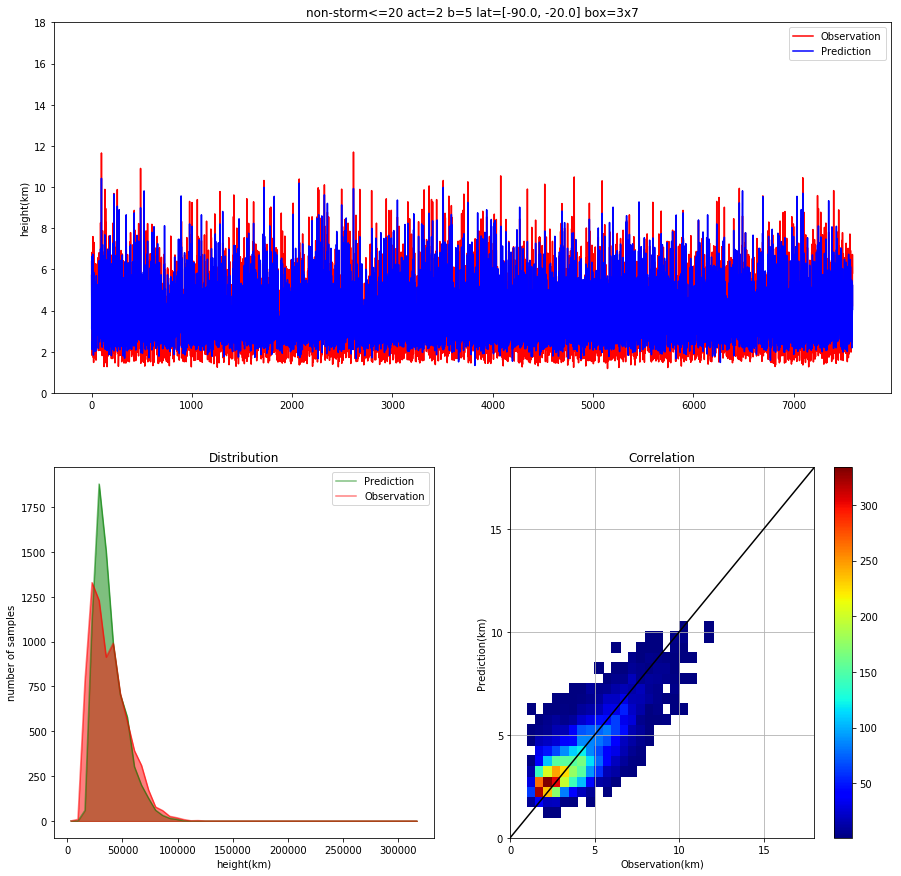

In [18]:
Figure(testY, prediction, 50)